In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import layers, mixed_precision
from keras.datasets import fashion_mnist, imdb, cifar10
from keras.metrics import Precision, Recall, F1Score, AUC
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Dropout, Conv2D, MaxPooling2D, GlobalMaxPool2D, Input, Embedding, SimpleRNN, BatchNormalization
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.constraints import max_norm
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, BackupAndRestore, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from plot_history_lib import plot_history, plot_precision_recall, plot_confusion_matrix, plot_metrics

/tmp/ipykernel_23163/1535145174.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-21 14:10:52.087954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 14:10:52.088158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 14:10:52.132825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [3]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

size_dataset = X_train.shape[0]
size_test_dataset = X_test.shape[0]
size_vall_dataset = X_valid.shape[0]

batch_size = 128

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, start_from_epoch=10, verbose=1)
backup = BackupAndRestore(backup_dir="/home/alex/Python_projects/HW_Data_Science/backup", save_freq=5, delete_checkpoint=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=25, min_lr=0.00045)

log_dir = "/home/alex/Python_projects/HW_Data_Science/log/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
precision_per_class = [Precision(class_id=i, name=f'precision_class{i}') for i in range(10)]
recall_per_class = [Recall(class_id=i, name=f'recall_class{i}') for i in range(10)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

2024-02-21 14:10:56.100990: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 14:10:56.232761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 14:10:56.232986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

class MyFilterModelMP():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(
                units=64,
                activation='relu'
            ),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=10,
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

In [9]:
filtermodel = MyFilterModelMP()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=50,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, backup, tensorboard]
)

2024-02-21 14:10:57.030876: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-02-21 14:11:02.816914: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f69e0008760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 14:11:02.816935: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-02-21 14:11:02.960029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-21 14:11:03.266520: I external/local_xla/xla/stream_executor/c

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2269 - loss: 2.1314 - precision_class0: 0.3434 - precision_class1: 0.3547 - precision_class2: 0.3731 - precision_class3: 0.0000e+00 - precision_class4: 0.0765 - precision_class5: 0.2537 - precision_class6: 0.3651 - precision_class7: 0.0900 - precision_class8: 0.5224 - precision_class9: 0.0000e+00 - recall_class0: 0.0054 - recall_class1: 0.0019 - recall_class2: 0.0028 - recall_class3: 0.0000e+00 - recall_class4: 3.2714e-04 - recall_class5: 0.0068 - recall_class6: 0.0032 - recall_class7: 9.6502e-05 - recall_class8: 0.0385 - recall_class9: 0.0000e+00                            

2024-02-21 14:11:19.011943: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17694720 exceeds 10% of free system memory.
2024-02-21 14:11:19.024113: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35389440 exceeds 10% of free system memory.
2024-02-21 14:11:19.044742: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 70778880 exceeds 10% of free system memory.
2024-02-21 14:11:19.075062: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141557760 exceeds 10% of free system memory.
2024-02-21 14:11:19.117888: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141557760 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.2277 - loss: 2.1296 - precision_class0: 0.3475 - precision_class1: 0.3588 - precision_class2: 0.3768 - precision_class3: 0.0000e+00 - precision_class4: 0.0843 - precision_class5: 0.2577 - precision_class6: 0.3679 - precision_class7: 0.0990 - precision_class8: 0.5243 - precision_class9: 0.0000e+00 - recall_class0: 0.0057 - recall_class1: 0.0020 - recall_class2: 0.0029 - recall_class3: 0.0000e+00 - recall_class4: 3.6999e-04 - recall_class5: 0.0070 - recall_class6: 0.0033 - recall_class7: 1.1855e-04 - recall_class8: 0.0392 - recall_class9: 0.0000e+00 - val_accuracy: 0.4159 - val_loss: 1.6599 - val_precision_class0: 0.7386 - val_precision_class1: 0.6486 - val_precision_class2: 0.7429 - val_precision_class3: 0.0000e+00 - val_precision_class4: 0.8333 - val_precision_class5: 0.7216 - val_precision_class6: 0.6450 - val_precision_class7: 0.8333 - val_precision_class8: 0.7785 - val_precision_class9: 1.0000 - val_recall_class0: 0.2025 - va

2024-02-21 14:11:29.916656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832
/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.4155 - loss: 1.6858 - precision_class0: 0.7282 - precision_class1: 0.6520 - precision_class2: 0.4906 - precision_class3: 0.7886 - precision_class4: 0.7096 - precision_class5: 0.6773 - precision_class6: 0.7274 - precision_class7: 0.8530 - precision_class8: 0.6842 - precision_class9: 0.5083 - recall_class0: 0.1750 - recall_class1: 0.1123 - recall_class2: 0.0186 - recall_class3: 0.0141 - recall_class4: 0.0435 - recall_class5: 0.1105 - recall_class6: 0.1400 - recall_class7: 0.0827 - recall_class8: 0.2333 - recall_class9: 0.0061 - val_accuracy: 0.4819 - val_loss: 1.4937 - val_precision_class0: 0.7186 - val_precision_class1: 0.6993 - val_precision_class2: 0.8000 - val_precision_class3: 0.6538 - val_precision_class4: 0.7692 - val_precision_class5: 0.7879 - val_precision_class6: 0.7364 - val_precision_class7: 0.8000 - val_precision_class8: 0.8241 - val_precision_class9: 0.6585 - val_recall_class0: 0.3306 - val_recall_class1: 0.2660 - va

2024-02-21 14:11:45.408575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:11:45.408604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4679 - loss: 1.5246 - precision_class0: 0.7396 - precision_class1: 0.6641 - precision_class2: 0.6119 - precision_class3: 0.6082 - precision_class4: 0.6955 - precision_class5: 0.6852 - precision_class6: 0.7445 - precision_class7: 0.7492 - precision_class8: 0.7089 - precision_class9: 0.6531 - recall_class0: 0.3108 - recall_class1: 0.2407 - recall_class2: 0.0821 - recall_class3: 0.0631 - recall_class4: 0.1563 - recall_class5: 0.1783 - recall_class6: 0.2781 - recall_class7: 0.2537 - recall_class8: 0.3722 - recall_class9: 0.0505 - val_accuracy: 0.5017 - val_loss: 1.4304 - val_precision_class0: 0.6923 - val_precision_class1: 0.6204 - val_precision_class2: 0.7273 - val_precision_class3: 0.7647 - val_precision_class4: 0.7742 - val_precision_class5: 0.6694 - val_precision_class6: 0.6875 - val_precision_class7: 0.8214 - val_precision_class8: 0.7865 - val_precision_class9: 0.6234 - val_recall_class0: 0.4513 - val_recall_class1: 0.3775 - val_

2024-02-21 14:12:16.002671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4969 - loss: 1.4216 - precision_class0: 0.7619 - precision_class1: 0.6695 - precision_class2: 0.6493 - precision_class3: 0.6132 - precision_class4: 0.7070 - precision_class5: 0.6835 - precision_class6: 0.6792 - precision_class7: 0.8014 - precision_class8: 0.7595 - precision_class9: 0.6102 - recall_class0: 0.4084 - recall_class1: 0.3190 - recall_class2: 0.1574 - recall_class3: 0.0931 - recall_class4: 0.2284 - recall_class5: 0.1923 - recall_class6: 0.3538 - recall_class7: 0.3476 - recall_class8: 0.4493 - recall_class9: 0.1680 - val_accuracy: 0.5314 - val_loss: 1.3289 - val_precision_class0: 0.7227 - val_precision_class1: 0.6528 - val_precision_class2: 0.7229 - val_precision_class3: 0.7143 - val_precision_class4: 0.7273 - val_precision_class5: 0.7304 - val_precision_class6: 0.6480 - val_precision_class7: 0.7548 - val_precision_class8: 0.8107 - val_precision_class9: 0.7500 - val_recall_class0: 0.4957 - val_recall_class1: 0.4017 - val_

2024-02-21 14:12:46.686724: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:12:46.686753: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5158 - loss: 1.3918 - precision_class0: 0.7356 - precision_class1: 0.6520 - precision_class2: 0.7257 - precision_class3: 0.6543 - precision_class4: 0.6804 - precision_class5: 0.7051 - precision_class6: 0.6854 - precision_class7: 0.7553 - precision_class8: 0.7240 - precision_class9: 0.7047 - recall_class0: 0.4227 - recall_class1: 0.3288 - recall_class2: 0.2228 - recall_class3: 0.1032 - recall_class4: 0.2718 - recall_class5: 0.2183 - recall_class6: 0.3456 - recall_class7: 0.3389 - recall_class8: 0.4574 - recall_class9: 0.2484 - val_accuracy: 0.5511 - val_loss: 1.2763 - val_precision_class0: 0.7695 - val_precision_class1: 0.7530 - val_precision_class2: 0.7750 - val_precision_class3: 0.8148 - val_precision_class4: 0.7634 - val_precision_class5: 0.6889 - val_precision_class6: 0.6227 - val_precision_class7: 0.7870 - val_precision_class8: 0.8194 - val_precision_class9: 0.7351 - val_recall_class0: 0.5027 - val_recall_class1: 0.4987 - val_

2024-02-21 14:13:21.896030: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:13:21.896066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5359 - loss: 1.3362 - precision_class0: 0.7626 - precision_class1: 0.7045 - precision_class2: 0.6874 - precision_class3: 0.6253 - precision_class4: 0.6728 - precision_class5: 0.7235 - precision_class6: 0.6653 - precision_class7: 0.7564 - precision_class8: 0.7493 - precision_class9: 0.6595 - recall_class0: 0.4444 - recall_class1: 0.3664 - recall_class2: 0.2474 - recall_class3: 0.1011 - recall_class4: 0.2321 - recall_class5: 0.2775 - recall_class6: 0.3829 - recall_class7: 0.4069 - recall_class8: 0.5254 - recall_class9: 0.2971 - val_accuracy: 0.5533 - val_loss: 1.2798 - val_precision_class0: 0.7080 - val_precision_class1: 0.7078 - val_precision_class2: 0.6923 - val_precision_class3: 0.7632 - val_precision_class4: 0.8028 - val_precision_class5: 0.6667 - val_precision_class6: 0.6142 - val_precision_class7: 0.7629 - val_precision_class8: 0.8671 - val_precision_class9: 0.6900 - val_recall_class0: 0.6122 - val_recall_class1: 0.4532 - val_

2024-02-21 14:13:54.478760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5226 - loss: 1.3530 - precision_class0: 0.7110 - precision_class1: 0.7201 - precision_class2: 0.6355 - precision_class3: 0.6919 - precision_class4: 0.6634 - precision_class5: 0.7507 - precision_class6: 0.6794 - precision_class7: 0.7399 - precision_class8: 0.7414 - precision_class9: 0.6528 - recall_class0: 0.4120 - recall_class1: 0.4103 - recall_class2: 0.1849 - recall_class3: 0.1321 - recall_class4: 0.2592 - recall_class5: 0.2635 - recall_class6: 0.3373 - recall_class7: 0.3705 - recall_class8: 0.4768 - recall_class9: 0.2991 - val_accuracy: 0.5514 - val_loss: 1.2663 - val_precision_class0: 0.8168 - val_precision_class1: 0.6655 - val_precision_class2: 0.6404 - val_precision_class3: 0.8000 - val_precision_class4: 0.8182 - val_precision_class5: 0.7355 - val_precision_class6: 0.6193 - val_precision_class7: 0.7401 - val_precision_class8: 0.8100 - val_precision_class9: 0.6130 - val_recall_class0: 0.4286 - val_recall_class1: 0.5372 - val_

2024-02-21 14:14:32.546978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:14:32.547011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5292 - loss: 1.3356 - precision_class0: 0.7441 - precision_class1: 0.6712 - precision_class2: 0.6418 - precision_class3: 0.5781 - precision_class4: 0.6755 - precision_class5: 0.7440 - precision_class6: 0.7363 - precision_class7: 0.7126 - precision_class8: 0.7495 - precision_class9: 0.6177 - recall_class0: 0.4604 - recall_class1: 0.4202 - recall_class2: 0.2055 - recall_class3: 0.0974 - recall_class4: 0.2985 - recall_class5: 0.2444 - recall_class6: 0.3911 - recall_class7: 0.4139 - recall_class8: 0.5269 - recall_class9: 0.2703 - val_accuracy: 0.5719 - val_loss: 1.2252 - val_precision_class0: 0.7422 - val_precision_class1: 0.7255 - val_precision_class2: 0.6453 - val_precision_class3: 0.7727 - val_precision_class4: 0.8269 - val_precision_class5: 0.6980 - val_precision_class6: 0.6697 - val_precision_class7: 0.7577 - val_precision_class8: 0.8386 - val_precision_class9: 0.6133 - val_recall_class0: 0.4974 - val_recall_class1: 0.4471 - val_

2024-02-21 14:15:08.993003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:15:08.993035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5360 - loss: 1.3283 - precision_class0: 0.7111 - precision_class1: 0.7044 - precision_class2: 0.6802 - precision_class3: 0.6226 - precision_class4: 0.7121 - precision_class5: 0.6951 - precision_class6: 0.7132 - precision_class7: 0.7249 - precision_class8: 0.7454 - precision_class9: 0.6730 - recall_class0: 0.4262 - recall_class1: 0.4213 - recall_class2: 0.2351 - recall_class3: 0.1358 - recall_class4: 0.2950 - recall_class5: 0.2667 - recall_class6: 0.4093 - recall_class7: 0.3989 - recall_class8: 0.5083 - recall_class9: 0.2769 - val_accuracy: 0.5731 - val_loss: 1.2056 - val_precision_class0: 0.7605 - val_precision_class1: 0.7532 - val_precision_class2: 0.7765 - val_precision_class3: 0.6515 - val_precision_class4: 0.6818 - val_precision_class5: 0.6966 - val_precision_class6: 0.6571 - val_precision_class7: 0.7559 - val_precision_class8: 0.8077 - val_precision_class9: 0.6939 - val_recall_class0: 0.5602 - val_recall_class1: 0.4797 - val_

2024-02-21 14:15:46.391842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:15:46.391874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5402 - loss: 1.3025 - precision_class0: 0.7646 - precision_class1: 0.6871 - precision_class2: 0.6623 - precision_class3: 0.5777 - precision_class4: 0.6947 - precision_class5: 0.6945 - precision_class6: 0.7100 - precision_class7: 0.7292 - precision_class8: 0.7712 - precision_class9: 0.7140 - recall_class0: 0.4763 - recall_class1: 0.4232 - recall_class2: 0.2452 - recall_class3: 0.1503 - recall_class4: 0.2973 - recall_class5: 0.2650 - recall_class6: 0.4071 - recall_class7: 0.4069 - recall_class8: 0.5375 - recall_class9: 0.3477 - val_accuracy: 0.5728 - val_loss: 1.2090 - val_precision_class0: 0.7664 - val_precision_class1: 0.6290 - val_precision_class2: 0.7800 - val_precision_class3: 0.6842 - val_precision_class4: 0.7451 - val_precision_class5: 0.7769 - val_precision_class6: 0.6361 - val_precision_class7: 0.7512 - val_precision_class8: 0.8564 - val_precision_class9: 0.6870 - val_recall_class0: 0.5738 - val_recall_class1: 0.5432 - val_

2024-02-21 14:16:20.602579: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:16:20.602603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5538 - loss: 1.2939 - precision_class0: 0.7259 - precision_class1: 0.7047 - precision_class2: 0.6645 - precision_class3: 0.6364 - precision_class4: 0.7131 - precision_class5: 0.6719 - precision_class6: 0.7340 - precision_class7: 0.7428 - precision_class8: 0.7413 - precision_class9: 0.7026 - recall_class0: 0.4977 - recall_class1: 0.4160 - recall_class2: 0.2551 - recall_class3: 0.1147 - recall_class4: 0.2944 - recall_class5: 0.2701 - recall_class6: 0.4595 - recall_class7: 0.4530 - recall_class8: 0.5246 - recall_class9: 0.3421 - val_accuracy: 0.5900 - val_loss: 1.1849 - val_precision_class0: 0.7538 - val_precision_class1: 0.7687 - val_precision_class2: 0.7586 - val_precision_class3: 0.7750 - val_precision_class4: 0.7949 - val_precision_class5: 0.6524 - val_precision_class6: 0.6848 - val_precision_class7: 0.8155 - val_precision_class8: 0.8197 - val_precision_class9: 0.6329 - val_recall_class0: 0.5512 - val_recall_class1: 0.5583 - val_

2024-02-21 14:16:53.117308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:16:53.117334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5607 - loss: 1.2753 - precision_class0: 0.7495 - precision_class1: 0.7522 - precision_class2: 0.7617 - precision_class3: 0.6569 - precision_class4: 0.6634 - precision_class5: 0.6885 - precision_class6: 0.7370 - precision_class7: 0.7339 - precision_class8: 0.7542 - precision_class9: 0.6922 - recall_class0: 0.5000 - recall_class1: 0.4575 - recall_class2: 0.2553 - recall_class3: 0.1322 - recall_class4: 0.2589 - recall_class5: 0.2889 - recall_class6: 0.4346 - recall_class7: 0.4207 - recall_class8: 0.5533 - recall_class9: 0.3522 - val_accuracy: 0.5678 - val_loss: 1.2319 - val_precision_class0: 0.7768 - val_precision_class1: 0.6680 - val_precision_class2: 0.7182 - val_precision_class3: 0.8235 - val_precision_class4: 0.7843 - val_precision_class5: 0.6845 - val_precision_class6: 0.6477 - val_precision_class7: 0.7917 - val_precision_class8: 0.8357 - val_precision_class9: 0.6273 - val_recall_class0: 0.5099 - val_recall_class1: 0.4817 - val_

2024-02-21 14:17:26.354615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5492 - loss: 1.2828 - precision_class0: 0.7365 - precision_class1: 0.7207 - precision_class2: 0.6790 - precision_class3: 0.6562 - precision_class4: 0.6300 - precision_class5: 0.6701 - precision_class6: 0.7585 - precision_class7: 0.7643 - precision_class8: 0.7696 - precision_class9: 0.7158 - recall_class0: 0.4875 - recall_class1: 0.4763 - recall_class2: 0.2559 - recall_class3: 0.1525 - recall_class4: 0.2537 - recall_class5: 0.2462 - recall_class6: 0.4843 - recall_class7: 0.4322 - recall_class8: 0.5180 - recall_class9: 0.3442 - val_accuracy: 0.5783 - val_loss: 1.2047 - val_precision_class0: 0.7920 - val_precision_class1: 0.6873 - val_precision_class2: 0.7200 - val_precision_class3: 0.6735 - val_precision_class4: 0.7984 - val_precision_class5: 0.6619 - val_precision_class6: 0.6826 - val_precision_class7: 0.7148 - val_precision_class8: 0.8640 - val_precision_class9: 0.6831 - val_recall_class0: 0.5726 - val_recall_class1: 0.5462 - val_

2024-02-21 14:17:48.478435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:17:48.478469: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5533 - loss: 1.2860 - precision_class0: 0.7738 - precision_class1: 0.7187 - precision_class2: 0.6858 - precision_class3: 0.5353 - precision_class4: 0.6976 - precision_class5: 0.6681 - precision_class6: 0.7266 - precision_class7: 0.7303 - precision_class8: 0.7660 - precision_class9: 0.6786 - recall_class0: 0.4925 - recall_class1: 0.4488 - recall_class2: 0.2592 - recall_class3: 0.1351 - recall_class4: 0.2857 - recall_class5: 0.2995 - recall_class6: 0.4541 - recall_class7: 0.4336 - recall_class8: 0.5475 - recall_class9: 0.3595 - val_accuracy: 0.5794 - val_loss: 1.1948 - val_precision_class0: 0.7407 - val_precision_class1: 0.6996 - val_precision_class2: 0.7870 - val_precision_class3: 0.6316 - val_precision_class4: 0.7413 - val_precision_class5: 0.6765 - val_precision_class6: 0.6828 - val_precision_class7: 0.8155 - val_precision_class8: 0.7695 - val_precision_class9: 0.7175 - val_recall_class0: 0.5805 - val_recall_class1: 0.5365 - va

2024-02-21 14:18:03.258334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:18:03.258361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5377 - loss: 1.3035 - precision_class0: 0.7198 - precision_class1: 0.7059 - precision_class2: 0.6839 - precision_class3: 0.6804 - precision_class4: 0.6805 - precision_class5: 0.6959 - precision_class6: 0.7232 - precision_class7: 0.7095 - precision_class8: 0.7738 - precision_class9: 0.6727 - recall_class0: 0.4674 - recall_class1: 0.4344 - recall_class2: 0.2779 - recall_class3: 0.1534 - recall_class4: 0.3349 - recall_class5: 0.2904 - recall_class6: 0.4277 - recall_class7: 0.4151 - recall_class8: 0.5457 - recall_class9: 0.3549 - val_accuracy: 0.5781 - val_loss: 1.2193 - val_precision_class0: 0.7821 - val_precision_class1: 0.7348 - val_precision_class2: 0.7273 - val_precision_class3: 0.7826 - val_precision_class4: 0.7736 - val_precision_class5: 0.7211 - val_precision_class6: 0.5995 - val_precision_class7: 0.7909 - val_precision_class8: 0.8514 - val_precision_class9: 0.7040 - val_recall_class0: 0.5826 - val_recall_class1: 0.5419 - val_

2024-02-21 14:18:34.908899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:18:34.908927: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5478 - loss: 1.2801 - precision_class0: 0.7302 - precision_class1: 0.7232 - precision_class2: 0.6985 - precision_class3: 0.5349 - precision_class4: 0.6458 - precision_class5: 0.6964 - precision_class6: 0.7363 - precision_class7: 0.7381 - precision_class8: 0.7681 - precision_class9: 0.6962 - recall_class0: 0.4655 - recall_class1: 0.4499 - recall_class2: 0.2729 - recall_class3: 0.1143 - recall_class4: 0.2232 - recall_class5: 0.2880 - recall_class6: 0.4322 - recall_class7: 0.4586 - recall_class8: 0.5833 - recall_class9: 0.3753 - val_accuracy: 0.5667 - val_loss: 1.2036 - val_precision_class0: 0.7747 - val_precision_class1: 0.6891 - val_precision_class2: 0.7748 - val_precision_class3: 0.5918 - val_precision_class4: 0.7234 - val_precision_class5: 0.7259 - val_precision_class6: 0.6293 - val_precision_class7: 0.8031 - val_precision_class8: 0.8356 - val_precision_class9: 0.6527 - val_recall_class0: 0.5989 - val_recall_class1: 0.6022 - val_

2024-02-21 14:19:07.234368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:19:07.234402: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5564 - loss: 1.2780 - precision_class0: 0.7776 - precision_class1: 0.7541 - precision_class2: 0.7503 - precision_class3: 0.6349 - precision_class4: 0.6620 - precision_class5: 0.7264 - precision_class6: 0.6819 - precision_class7: 0.7297 - precision_class8: 0.7485 - precision_class9: 0.6947 - recall_class0: 0.5058 - recall_class1: 0.4535 - recall_class2: 0.2940 - recall_class3: 0.1606 - recall_class4: 0.2737 - recall_class5: 0.3058 - recall_class6: 0.4123 - recall_class7: 0.4297 - recall_class8: 0.5720 - recall_class9: 0.3969 - val_accuracy: 0.5725 - val_loss: 1.1924 - val_precision_class0: 0.8130 - val_precision_class1: 0.6929 - val_precision_class2: 0.7881 - val_precision_class3: 0.6210 - val_precision_class4: 0.7717 - val_precision_class5: 0.7553 - val_precision_class6: 0.6399 - val_precision_class7: 0.7490 - val_precision_class8: 0.7962 - val_precision_class9: 0.6822 - val_recall_class0: 0.5436 - val_recall_class1: 0.5161 - val_

2024-02-21 14:19:41.647387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:19:41.647413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5665 - loss: 1.2396 - precision_class0: 0.7435 - precision_class1: 0.7695 - precision_class2: 0.6754 - precision_class3: 0.5812 - precision_class4: 0.6966 - precision_class5: 0.6882 - precision_class6: 0.7370 - precision_class7: 0.8081 - precision_class8: 0.7769 - precision_class9: 0.6965 - recall_class0: 0.5202 - recall_class1: 0.5029 - recall_class2: 0.2748 - recall_class3: 0.1511 - recall_class4: 0.2957 - recall_class5: 0.3304 - recall_class6: 0.4592 - recall_class7: 0.4272 - recall_class8: 0.5674 - recall_class9: 0.3777 - val_accuracy: 0.5706 - val_loss: 1.2185 - val_precision_class0: 0.7490 - val_precision_class1: 0.7243 - val_precision_class2: 0.7805 - val_precision_class3: 0.6471 - val_precision_class4: 0.7981 - val_precision_class5: 0.6761 - val_precision_class6: 0.6501 - val_precision_class7: 0.8093 - val_precision_class8: 0.7790 - val_precision_class9: 0.6550 - val_recall_class0: 0.5184 - val_recall_class1: 0.5350 - val_

2024-02-21 14:20:17.415922: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:20:17.415954: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5704 - loss: 1.2320 - precision_class0: 0.7780 - precision_class1: 0.7127 - precision_class2: 0.7409 - precision_class3: 0.7311 - precision_class4: 0.7102 - precision_class5: 0.6919 - precision_class6: 0.7473 - precision_class7: 0.7458 - precision_class8: 0.7760 - precision_class9: 0.6614 - recall_class0: 0.5364 - recall_class1: 0.4660 - recall_class2: 0.2815 - recall_class3: 0.1706 - recall_class4: 0.3350 - recall_class5: 0.2971 - recall_class6: 0.4404 - recall_class7: 0.4461 - recall_class8: 0.5840 - recall_class9: 0.3706 - val_accuracy: 0.5831 - val_loss: 1.2135 - val_precision_class0: 0.7993 - val_precision_class1: 0.6990 - val_precision_class2: 0.7333 - val_precision_class3: 0.6923 - val_precision_class4: 0.8144 - val_precision_class5: 0.7083 - val_precision_class6: 0.6374 - val_precision_class7: 0.7395 - val_precision_class8: 0.8189 - val_precision_class9: 0.6691 - val_recall_class0: 0.5658 - val_recall_class1: 0.5459 - val_

2024-02-21 14:20:54.349949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:20:54.349979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5604 - loss: 1.2559 - precision_class0: 0.7321 - precision_class1: 0.7086 - precision_class2: 0.7497 - precision_class3: 0.5353 - precision_class4: 0.7014 - precision_class5: 0.7296 - precision_class6: 0.6997 - precision_class7: 0.7219 - precision_class8: 0.7491 - precision_class9: 0.7251 - recall_class0: 0.4808 - recall_class1: 0.4272 - recall_class2: 0.2892 - recall_class3: 0.1080 - recall_class4: 0.3146 - recall_class5: 0.3155 - recall_class6: 0.4464 - recall_class7: 0.4273 - recall_class8: 0.5390 - recall_class9: 0.3908 - val_accuracy: 0.5889 - val_loss: 1.1542 - val_precision_class0: 0.7905 - val_precision_class1: 0.7077 - val_precision_class2: 0.8571 - val_precision_class3: 0.6897 - val_precision_class4: 0.8208 - val_precision_class5: 0.7660 - val_precision_class6: 0.6469 - val_precision_class7: 0.7548 - val_precision_class8: 0.7937 - val_precision_class9: 0.7135 - val_recall_class0: 0.6047 - val_recall_class1: 0.5710 - val_

2024-02-21 14:21:30.430899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:21:30.430936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5676 - loss: 1.2405 - precision_class0: 0.7532 - precision_class1: 0.7507 - precision_class2: 0.7126 - precision_class3: 0.6826 - precision_class4: 0.6922 - precision_class5: 0.6910 - precision_class6: 0.7304 - precision_class7: 0.8038 - precision_class8: 0.7955 - precision_class9: 0.6300 - recall_class0: 0.5134 - recall_class1: 0.4766 - recall_class2: 0.2755 - recall_class3: 0.1499 - recall_class4: 0.2855 - recall_class5: 0.3082 - recall_class6: 0.4494 - recall_class7: 0.4835 - recall_class8: 0.5930 - recall_class9: 0.3559 - val_accuracy: 0.5797 - val_loss: 1.1721 - val_precision_class0: 0.7838 - val_precision_class1: 0.6545 - val_precision_class2: 0.7521 - val_precision_class3: 0.7500 - val_precision_class4: 0.7593 - val_precision_class5: 0.6701 - val_precision_class6: 0.6900 - val_precision_class7: 0.7623 - val_precision_class8: 0.8578 - val_precision_class9: 0.7444 - val_recall_class0: 0.5833 - val_recall_class1: 0.6366 - val_

2024-02-21 14:22:03.778652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:22:03.778684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5634 - loss: 1.2416 - precision_class0: 0.7926 - precision_class1: 0.7185 - precision_class2: 0.7377 - precision_class3: 0.6097 - precision_class4: 0.6753 - precision_class5: 0.7069 - precision_class6: 0.7127 - precision_class7: 0.7669 - precision_class8: 0.7995 - precision_class9: 0.7073 - recall_class0: 0.5220 - recall_class1: 0.4234 - recall_class2: 0.3066 - recall_class3: 0.1349 - recall_class4: 0.3042 - recall_class5: 0.3104 - recall_class6: 0.4595 - recall_class7: 0.4454 - recall_class8: 0.5883 - recall_class9: 0.3900 - val_accuracy: 0.5781 - val_loss: 1.2223 - val_precision_class0: 0.7844 - val_precision_class1: 0.7116 - val_precision_class2: 0.7742 - val_precision_class3: 0.6154 - val_precision_class4: 0.7563 - val_precision_class5: 0.7655 - val_precision_class6: 0.5698 - val_precision_class7: 0.7733 - val_precision_class8: 0.8125 - val_precision_class9: 0.7183 - val_recall_class0: 0.5734 - val_recall_class1: 0.6412 - val_

2024-02-21 14:23:13.455587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:23:13.455619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5668 - loss: 1.2304 - precision_class0: 0.7648 - precision_class1: 0.7675 - precision_class2: 0.7444 - precision_class3: 0.6217 - precision_class4: 0.6825 - precision_class5: 0.6775 - precision_class6: 0.7367 - precision_class7: 0.7725 - precision_class8: 0.7822 - precision_class9: 0.6816 - recall_class0: 0.5373 - recall_class1: 0.4710 - recall_class2: 0.3068 - recall_class3: 0.1667 - recall_class4: 0.3301 - recall_class5: 0.3054 - recall_class6: 0.4135 - recall_class7: 0.4420 - recall_class8: 0.6390 - recall_class9: 0.4094 - val_accuracy: 0.5797 - val_loss: 1.1885 - val_precision_class0: 0.7868 - val_precision_class1: 0.6514 - val_precision_class2: 0.7733 - val_precision_class3: 0.6449 - val_precision_class4: 0.7203 - val_precision_class5: 0.7267 - val_precision_class6: 0.6755 - val_precision_class7: 0.7727 - val_precision_class8: 0.8108 - val_precision_class9: 0.6829 - val_recall_class0: 0.5815 - val_recall_class1: 0.5852 - val_

2024-02-21 14:24:21.811817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:24:21.811847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5571 - loss: 1.2498 - precision_class0: 0.7385 - precision_class1: 0.7052 - precision_class2: 0.6718 - precision_class3: 0.5534 - precision_class4: 0.7251 - precision_class5: 0.6379 - precision_class6: 0.7495 - precision_class7: 0.7384 - precision_class8: 0.7582 - precision_class9: 0.7102 - recall_class0: 0.4890 - recall_class1: 0.4652 - recall_class2: 0.2918 - recall_class3: 0.1233 - recall_class4: 0.3487 - recall_class5: 0.3032 - recall_class6: 0.4465 - recall_class7: 0.4459 - recall_class8: 0.5770 - recall_class9: 0.3680 - val_accuracy: 0.5869 - val_loss: 1.1729 - val_precision_class0: 0.7821 - val_precision_class1: 0.7491 - val_precision_class2: 0.7765 - val_precision_class3: 0.5946 - val_precision_class4: 0.8283 - val_precision_class5: 0.7465 - val_precision_class6: 0.6069 - val_precision_class7: 0.7975 - val_precision_class8: 0.8526 - val_precision_class9: 0.6421 - val_recall_class0: 0.5382 - val_recall_class1: 0.5464 - val_

2024-02-21 14:24:56.274724: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:24:56.274757: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5765 - loss: 1.2154 - precision_class0: 0.7359 - precision_class1: 0.7413 - precision_class2: 0.7331 - precision_class3: 0.6395 - precision_class4: 0.7253 - precision_class5: 0.6975 - precision_class6: 0.7090 - precision_class7: 0.7375 - precision_class8: 0.7552 - precision_class9: 0.7069 - recall_class0: 0.5073 - recall_class1: 0.4705 - recall_class2: 0.3158 - recall_class3: 0.1782 - recall_class4: 0.3275 - recall_class5: 0.3301 - recall_class6: 0.4660 - recall_class7: 0.4343 - recall_class8: 0.5628 - recall_class9: 0.4026 - val_accuracy: 0.5903 - val_loss: 1.1824 - val_precision_class0: 0.8212 - val_precision_class1: 0.6958 - val_precision_class2: 0.7683 - val_precision_class3: 0.5789 - val_precision_class4: 0.6412 - val_precision_class5: 0.7399 - val_precision_class6: 0.6229 - val_precision_class7: 0.7991 - val_precision_class8: 0.8367 - val_precision_class9: 0.6432 - val_recall_class0: 0.5937 - val_recall_class1: 0.6417 - val_

2024-02-21 14:25:33.671037: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16663808635339491035
2024-02-21 14:25:33.671071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7234333166493145832


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5678 - loss: 1.2462 - precision_class0: 0.7749 - precision_class1: 0.7333 - precision_class2: 0.6805 - precision_class3: 0.6892 - precision_class4: 0.6739 - precision_class5: 0.6867 - precision_class6: 0.7166 - precision_class7: 0.7323 - precision_class8: 0.7724 - precision_class9: 0.6612 - recall_class0: 0.5116 - recall_class1: 0.4636 - recall_class2: 0.2920 - recall_class3: 0.1750 - recall_class4: 0.2795 - recall_class5: 0.3050 - recall_class6: 0.5020 - recall_class7: 0.4199 - recall_class8: 0.6194 - recall_class9: 0.3953 - val_accuracy: 0.5922 - val_loss: 1.1786 - val_precision_class0: 0.7765 - val_precision_class1: 0.6906 - val_precision_class2: 0.7692 - val_precision_class3: 0.6436 - val_precision_class4: 0.7925 - val_precision_class5: 0.7609 - val_precision_class6: 0.5982 - val_precision_class7: 0.8203 - val_precision_class8: 0.8020 - val_precision_class9: 0.7598 - val_recall_class0: 0.5593 - val_recall_class1: 0.6006 - val_

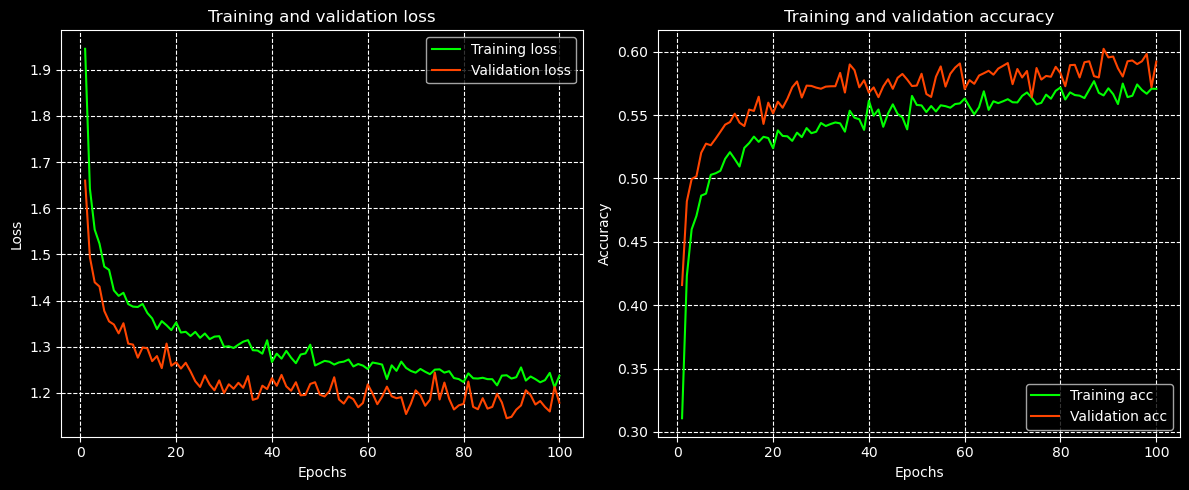

In [10]:
plot_history(history)

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model_filter.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=all_metrics
)

In [13]:
history = model_filter.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, backup, tensorboard]
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3727 - loss: 1.9089 - precision_class0: 0.7030 - precision_class1: 0.6423 - precision_class2: 0.6833 - precision_class3: 0.6288 - precision_class4: 0.7233 - precision_class5: 0.6942 - precision_class6: 0.6031 - precision_class7: 0.6959 - precision_class8: 0.6861 - precision_class9: 0.6686 - recall_class0: 0.3606 - recall_class1: 0.3390 - recall_class2: 0.1314 - recall_class3: 0.0531 - recall_class4: 0.1141 - recall_class5: 0.1539 - recall_class6: 0.3138 - recall_class7: 0.3032 - recall_class8: 0.4085 - recall_class9: 0.2167 

/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.3730 - loss: 1.9077 - precision_class0: 0.7031 - precision_class1: 0.6424 - precision_class2: 0.6833 - precision_class3: 0.6287 - precision_class4: 0.7232 - precision_class5: 0.6941 - precision_class6: 0.6033 - precision_class7: 0.6960 - precision_class8: 0.6862 - precision_class9: 0.6686 - recall_class0: 0.3608 - recall_class1: 0.3393 - recall_class2: 0.1315 - recall_class3: 0.0531 - recall_class4: 0.1143 - recall_class5: 0.1541 - recall_class6: 0.3140 - recall_class7: 0.3034 - recall_class8: 0.4087 - recall_class9: 0.2170 - val_accuracy: 0.6358 - val_loss: 1.0144 - val_precision_class0: 0.8302 - val_precision_class1: 0.8084 - val_precision_class2: 0.7952 - val_precision_class3: 0.6379 - val_precision_class4: 0.8075 - val_precision_class5: 0.8106 - val_precision_class6: 0.6679 - val_precision_class7: 0.7778 - val_precision_class8: 0.9017 - val_precision_class9: 0.6777 - val_recall_class0: 0.6454 - val_recall_class1: 0.6873 - va

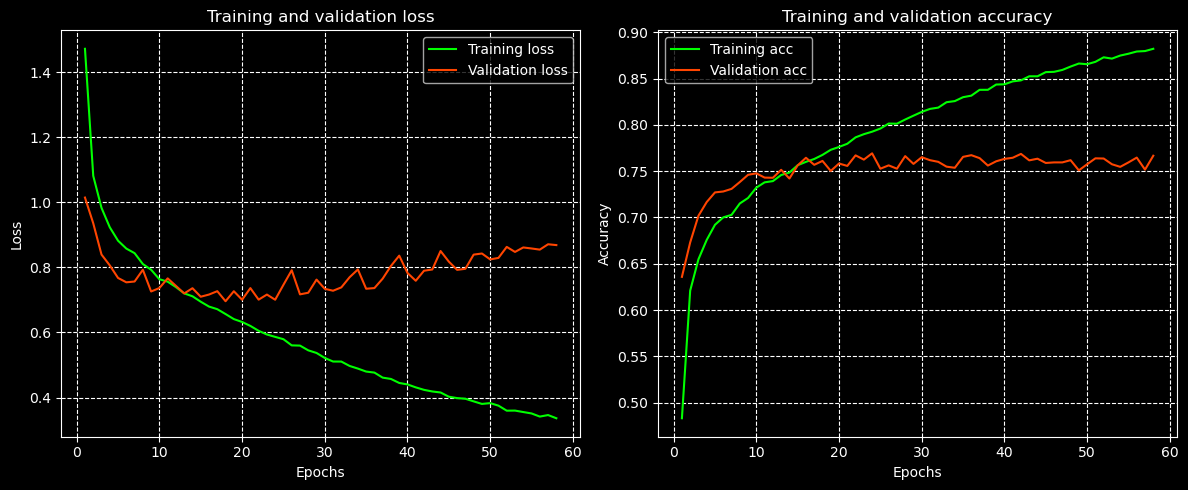

In [14]:
plot_history(history)